In [69]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Collaborative Filtering


In [40]:
interactions_df = pd.read_csv('clean_amazon.csv')
interactions_df.head(10)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,review_count
0,346,1158,10,399.00,1099.0,64.0,4.2,444,High Compatibility : Compatible With iPhone 12...,623,522,817,"Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,3
1,848,134,10,199.00,349.0,43.0,4.0,10103,"Compatible with all Type C enabled devices, be...",88,207,1025,"A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,3
2,819,1023,10,199.00,1899.0,90.0,3.9,9015,【 Fast Charger& Data Sync】-With built-in safet...,849,482,827,"Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,3
3,643,1264,10,329.00,699.0,53.0,4.2,14002,The boAt Deuce USB 300 2 in 1 cable is compati...,254,614,786,"Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,3
4,588,829,10,154.00,399.0,61.0,4.2,4803,[CHARGE & SYNC FUNCTION]- This cable comes wit...,17,1139,114,"As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,3
5,771,1328,10,149.00,1000.0,85.0,3.9,11303,Fast Charging & Data Sync: Solero TB301 Type-C...,210,428,961,"It's pretty good,Average quality,very good and...","It's a good product.,Like,Very good item stron...",https://m.media-amazon.com/images/I/31wOPjcSxl...,https://www.amazon.in/Solero-TB301-Charging-48...,3
6,761,1271,10,176.63,499.0,65.0,4.1,6783,It Ensures High Speed Transmission And Chargin...,662,1040,969,"Long durable.,good,Does not charge Lenovo m8 t...",Build quality is good and it is comes with 2 y...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/boAt-Micro-USB-Tangle-Fr...,3
7,614,658,10,229.00,299.0,23.0,4.3,2091,1m long Type-C USB Cable|Sturdy and Durable. W...,1162,631,637,"Worth for money - suitable for Android auto,Go...",Worth for money - suitable for Android auto......,https://m.media-amazon.com/images/I/31XO-wfGGG...,https://www.amazon.in/MI-MTCY001IN-USB-Type-C-...,3
8,15,1080,49,499.00,999.0,50.0,4.2,5495,USB WiFi Adapter —— Speedy wireless transmissi...,859,244,205,Works on linux for me. Get the model with ante...,I use this to connect an old PC to internet. I...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/TP-Link-TL-WN725N-150Mbp...,1
9,515,133,10,199.00,299.0,33.0,4.0,7682,Universal Compatibility – It is compatible wit...,88,207,1025,"A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,2


In [41]:
print(interactions_df.columns)
interactions_df['purchase_count_estimated'] = interactions_df['rating_count'] * 0.5  

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link', 'review_count'],
      dtype='object')


In [42]:
def classify_event(row):
    if row['rating'] >= 4.5 and row['rating_count'] > 5000 and row['purchase_count_estimated'] > 1000:
        return 'event_type_4'  # Sản phẩm HOT
    elif row['rating'] >= 4.0 and row['rating_count'] > 1000 and row['purchase_count_estimated'] > 500:
        return 'event_type_3'  # Sản phẩm phổ biến
    elif row['rating'] >= 3.0 and row['rating_count'] > 100 and row['purchase_count_estimated'] > 100:
        return 'event_type_2'  # Sản phẩm trung bình
    else:
        return 'event_type_1'  # Sản phẩm ít phổ biến

# Áp dụng vào DataFrame
interactions_df['eventType'] = interactions_df.apply(classify_event, axis=1)

# Xác định mức độ ảnh hưởng eventStrength dựa trên eventType
event_type_strength = {
    'event_type_1': 1.0,
    'event_type_2': 2.0,
    'event_type_3': 3.0,
    'event_type_4': 4.0
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength.get(x, 1.0))

# Kiểm tra kết quả
print(interactions_df[['eventType', 'eventStrength']].groupby('eventType').mean())
print(interactions_df[['eventType', 'eventStrength']].head())
print(interactions_df['eventStrength'].isnull().sum())  # Kiểm tra số giá trị NaN


              eventStrength
eventType                  
event_type_1            1.0
event_type_2            2.0
event_type_3            3.0
event_type_4            4.0
      eventType  eventStrength
0  event_type_2            2.0
1  event_type_3            3.0
2  event_type_2            2.0
3  event_type_3            3.0
4  event_type_3            3.0
0


In [43]:
print(interactions_df['user_id'].isna().sum())  
print((interactions_df['user_id'] == "").sum())  

users_interactions_summary_df = interactions_df.groupby('user_id').agg(
    review_count=('review_id', 'count'),  
    purchase_count_estimated=('purchase_count_estimated', 'sum')  
).reset_index()

print("Số lượng user_id duy nhất:", users_interactions_summary_df['user_id'].nunique())

print("Số lượng user_id bị thiếu:", users_interactions_summary_df['user_id'].isna().sum())
print(users_interactions_summary_df.describe())
users_interactions_summary_df = users_interactions_summary_df.sort_values(
    by=['review_count', 'purchase_count_estimated'], 
    ascending=[False, False]
)
print(users_interactions_summary_df.head(10))
 #Kiểm tra nếu có giá trị 0 hoặc âm trong cột 'purchase_count_estimated'
interactions_df['purchase_count_estimated'] = interactions_df['purchase_count_estimated'].replace(0, 1)  # Thay thế giá trị 0 bằng 1

# Áp dụng log-transform (log tự nhiên)
interactions_df['log_purchase_count'] = np.log(interactions_df['purchase_count_estimated'])

# Kiểm tra lại dữ liệu
print(interactions_df[['purchase_count_estimated', 'log_purchase_count']].head())


0
0
Số lượng user_id duy nhất: 1194
Số lượng user_id bị thiếu: 0
           user_id  review_count  purchase_count_estimated
count  1194.000000   1194.000000               1194.000000
mean    596.500000      1.226968               4498.376047
std     344.822418      0.772262               3704.064651
min       0.000000      1.000000                  6.000000
25%     298.250000      1.000000               2153.000000
50%     596.500000      1.000000               4063.750000
75%     894.750000      1.000000               6070.000000
max    1193.000000     10.000000              46932.500000
      user_id  review_count  purchase_count_estimated
1048     1048            10                   46932.5
623       623             8                   34217.5
674       674             8                   26940.5
254       254             7                   22717.5
88         88             7                   22483.0
1168     1168             6                   24666.5
633       633             

In [44]:
# Lọc những người dùng có ít nhất 5 tương tác
users_with_enough_interactions_df = interactions_df['user_id'].value_counts()[interactions_df['user_id'].value_counts() >= 5].index
users_with_enough_interactions_df = pd.DataFrame(users_with_enough_interactions_df, columns=['user_id'])
print(users_with_enough_interactions_df.head())
# Merge lại với DataFrame interactions_df để lấy các tương tác của người dùng có ít nhất 5 tương tác
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how='right',
               left_on='user_id',
               right_on='user_id')

# Kiểm tra số lượng tương tác của những người dùng này
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))


   user_id
0     1048
1      623
2      674
3       88
4      254
# of interactions from users with at least 5 interactions: 87


In [45]:
interactions_full_df = interactions_from_selected_users_df[['user_id', 'product_id', 'rating']]
print('# of unique user/item interactions: %d' % len(interactions_full_df))
print(interactions_full_df.head(10))

# Chia dữ liệu thành tập huấn luyện và kiểm tra
interactions_train_df, interactions_test_df = train_test_split(
    interactions_full_df,
    stratify=interactions_full_df['user_id'],  # Đảm bảo chia theo user_id
    test_size=0.20,
    random_state=42
)

# In kết quả
print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))


# of unique user/item interactions: 87
   user_id  product_id  rating
0     1048         985     4.0
1     1048         986     4.0
2     1048         987     4.0
3     1048        1176     4.0
4     1048        1173     4.0
5     1048         697     4.0
6     1048         693     4.0
7     1048         985     4.0
8     1048         989     4.0
9     1048         985     4.0
# interactions on Train set: 69
# interactions on Test set: 18


In [46]:
#tăng tốc độ tìm kiếm trong quá trình đánh giá
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [47]:
def get_items_interacted(person_id, interactions_df):
    # Lọc ra các dòng của người dùng với person_id tương ứng
    user_interactions = interactions_df[interactions_df['user_id'] == user_id]
    
    # Lấy danh sách các contentId mà người dùng đã tương tác
    interacted_items = user_interactions['product_id']
    
    # Trả về dưới dạng tập hợp (set)
    return set(interacted_items)


In [48]:
class ModelEvaluator:

    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        interacted_items = get_items_interacted(user_id, interactions_full_indexed_df)
        all_items = set(articles_df['product_id'])  # Chỉnh sửa từ 'contentId' thành 'product_id'
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, product_id, recommended_items, topn):        
        index = -1
        if product_id in recommended_items[:topn]:
            index = recommended_items.index(product_id)
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, user_id):
        # Getting the items in the test set
        interacted_values_testset = interactions_test_indexed_df.loc[user_id]
        if type(interacted_values_testset['product_id']) == pd.Series:
            user_interacted_items_testset = set(interacted_values_testset['product_id'])
        else:
            user_interacted_items_testset = set([int(interacted_values_testset['product_id'])])  
        interacted_items_count_testset = len(user_interacted_items_testset)

        # Getting a ranked recommendation list from the model for a given user
        user_recs_df = model.recommend_items(user_id, 
                                             items_to_ignore=get_items_interacted(user_id, 
                                                                                  interactions_train_indexed_df), 
                                             topn=10000000000)
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in the test set
        for product_id in user_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, 
                                                                              sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                              seed=product_id%(2**32))
            
            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([product_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = user_recs_df[user_recs_df['product_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['product_id'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(product_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(product_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
        
        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        user_metrics = {'hits@5_count': hits_at_5_count, 
                        'hits@10_count': hits_at_10_count, 
                        'interacted_count': interacted_items_count_testset,
                        'recall@5': recall_at_5,
                        'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        people_metrics = []
        for idx, user_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            user_metrics = self.evaluate_model_for_user(model, user_id)  
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)
            if idx % 100 == 0 and idx > 0:
                print(f'{idx} users processed')

        print(f'{len(people_metrics)} users processed')

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()


# Popularity model


In [49]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from typing import List, Dict, Optional, Tuple

In [50]:
df = pd.read_csv("clean_amazon.csv")
# Groupby theo product_id và tính tổng eventStrength
item_popularity_df = interactions_df.groupby('product_id')['eventStrength'].sum().sort_values(ascending=False).reset_index()
# In kết quả
print(item_popularity_df.head())


   product_id  eventStrength
0         877           11.0
1         472            9.0
2         589            9.0
3         643            9.0
4        1109            9.0


In [51]:
if 'interactions_df' in globals():
    print("interactions_df đã tồn tại")
    print(interactions_df.info())  # Kiểm tra thông tin DataFrame
else:
    print("interactions_df chưa được định nghĩa!")


interactions_df đã tồn tại
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   product_id                1465 non-null   int64  
 1   product_name              1465 non-null   int64  
 2   category                  1465 non-null   int64  
 3   discounted_price          1465 non-null   float64
 4   actual_price              1465 non-null   float64
 5   discount_percentage       1465 non-null   float64
 6   rating                    1465 non-null   float64
 7   rating_count              1465 non-null   int64  
 8   about_product             1465 non-null   object 
 9   user_id                   1465 non-null   int64  
 10  user_name                 1465 non-null   int64  
 11  review_id                 1465 non-null   int64  
 12  review_title              1465 non-null   object 
 13  review_content            1465 non-n

In [54]:
item_popularity_df = item_popularity_df.reset_index()

In [60]:
print(PopularityRecommender)


<class '__main__.PopularityRecommender'>


MSE - Sai số bình phương trung bình
(RMSE) - Sai số bình phương trung bình căn bậc hai
(MAE) - Sai số tuyệt đối trung bình
(MAPE) - Sai số phần trăm tuyệt đối trung bình
Recall@10 - Độ hồi lại @10

In [62]:
interactions_df['avg_rating'] = interactions_df['rating'] / interactions_df['rating_count']
popularity_model = PopularityRecommender(interactions_df)
popularity_model.popularity_df.rename(columns={'user_id': 'user_id'}, inplace=True)


In [67]:
def rating_bin(rating):
    """Helper function to bin ratings into categories"""
    if rating >= 4.5:
        return 3  # Rất cao
    elif rating >= 4.0:
        return 2  # Cao
    elif rating >= 3.0:
        return 1  # Trung bình
    else:
        return 0.5  # Thấp

def prepare_data(file_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Chuẩn bị dữ liệu từ file CSV"""
    try:
        # Đọc dữ liệu
        df = pd.read_csv(file_path)
        
        # Tạo interactions_df
        interactions_df = df[['user_id', 'product_id', 'rating']].dropna()

        # Tạo popularity_df với các metrics cơ bản
        popularity_df = df.groupby('product_id').agg({
            'rating': ['count', 'mean']
        }).reset_index()

        # Làm phẳng tên cột
        popularity_df.columns = ['product_id', 'rating_count', 'avg_rating']
        
        # Thêm rating_bin
        popularity_df['rating_bin'] = popularity_df['avg_rating'].apply(rating_bin)

        # Tính purchase_count nếu có, nếu không thì dùng rating_count
        if 'purchase_count_estimated' in df.columns:
            purchase_counts = df.groupby('product_id')['purchase_count_estimated'].sum().reset_index()
            popularity_df = popularity_df.merge(purchase_counts, on='product_id', how='left')
        else:
            # Nếu không có cột purchase_count_estimated, sử dụng rating_count thay thế
            popularity_df['purchase_count_estimated'] = popularity_df['rating_count']

        # Tính final_event_strength
        popularity_df['final_event_strength'] = (
            (popularity_df['avg_rating'] * 25) +  
            (popularity_df['rating_bin'] * 2) +  
            (np.log1p(popularity_df['rating_count']) * 1.5) +
            (np.log1p(popularity_df['purchase_count_estimated']) * 0.5)
        )
        
        return interactions_df, popularity_df

    except Exception as e:
        print(f"Lỗi khi đọc dữ liệu: {str(e)}")
        return None, None

class PopularityRecommender:
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df: pd.DataFrame, items_df: Optional[pd.DataFrame] = None, threshold: float = 3.0):
        """Khởi tạo recommender system"""
        self.popularity_df = popularity_df.copy()
        self.items_df = items_df
        
        # Đảm bảo product_id là kiểu int
        self.popularity_df['product_id'] = self.popularity_df['product_id'].astype(int)

        # Lọc sản phẩm có rating trung bình > threshold
        self.popularity_df = self.popularity_df[self.popularity_df['avg_rating'] > threshold]
        
        # Chuẩn hóa final_event_strength
        if 'final_event_strength' in self.popularity_df.columns:
            scaler = MinMaxScaler()
            self.popularity_df['final_event_strength'] = scaler.fit_transform(
                self.popularity_df[['final_event_strength']]
            )

    def recommend_items(self, 
                       user_id: Optional[int] = None,
                       items_to_ignore: List[int] = [],
                       topn: int = 10,
                       verbose: bool = False) -> pd.DataFrame:
        """Đưa ra recommendations"""
        recommendations_df = self.popularity_df[
            ~self.popularity_df['product_id'].isin(items_to_ignore)
        ].sort_values('final_event_strength', ascending=False).head(topn)
        
        if verbose and self.items_df is not None:
            recommendations_df = recommendations_df.merge(
                self.items_df,
                how='left',
                on='product_id'
            )
        
        return recommendations_df

class ModelEvaluator:
    def __init__(self, recommender: PopularityRecommender):
        """Khởi tạo evaluator"""
        self.recommender = recommender
    
    def evaluate_metrics(self, 
                        interactions_df: pd.DataFrame,
                        k: int = 10) -> Tuple[Dict[str, float], pd.DataFrame]:
        """Đánh giá model bằng nhiều metrics"""
        y_true = interactions_df.groupby('product_id')['rating'].count()
        y_pred = self.recommender.popularity_df.set_index('product_id')['final_event_strength']

        # Đảm bảo y_pred có cùng product_id với y_true
        common_products = y_true.index.intersection(y_pred.index)
        y_true, y_pred = y_true[common_products], y_pred[common_products]
        
        global_metrics = {
            'mse': mean_squared_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'mape': mean_absolute_percentage_error(y_true, y_pred)
        }
        
        # Tính Recall@K cho từng user
        user_metrics = []
        for user_id in interactions_df['user_id'].unique():
            user_items = interactions_df[
                interactions_df['user_id'] == user_id
            ]['product_id'].tolist()
            
            recs = self.recommender.recommend_items(
                user_id=user_id,
                topn=k
            )['product_id'].tolist()
            
            recall = len(set(recs) & set(user_items)) / len(user_items)
            user_metrics.append({
                'user_id': user_id,
                f'recall@{k}': recall
            })
        
        user_metrics_df = pd.DataFrame(user_metrics)
        global_metrics[f'mean_recall@{k}'] = user_metrics_df[f'recall@{k}'].mean()
        
        return global_metrics, user_metrics_df

def main():
    """Hàm main để chạy toàn bộ quy trình"""
    try:
        # 1. Chuẩn bị dữ liệu
        print("Đang chuẩn bị dữ liệu...")
        interactions_df, popularity_df = prepare_data("clean_amazon.csv")
        if interactions_df is None or popularity_df is None:
            return None, None, None, None
        
        # 2. Khởi tạo và train model
        print("\nĐang khởi tạo recommender system...")
        recommender = PopularityRecommender(popularity_df)
        
        # 3. Đánh giá model
        print("\nĐang đánh giá model...")
        evaluator = ModelEvaluator(recommender)
        metrics, user_metrics = evaluator.evaluate_metrics(interactions_df)
        
        # 4. In kết quả
        print("\nKết quả đánh giá:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        print("\nTop 10 recommendations:")
        recommendations = recommender.recommend_items(topn=10)
        print(recommendations[['product_id', 'final_event_strength']])
        
        # 5. So sánh với top rating
        print("\nSo sánh với top rating:")
        top_rated = popularity_df.sort_values('avg_rating', ascending=False).head(10)
        matching_products = set(recommendations['product_id']) & set(top_rated['product_id'])
        
        print(f"Số sản phẩm trùng khớp: {len(matching_products)}")
        print(f"Product IDs trùng khớp: {list(matching_products)}")
        
        return recommender, evaluator, metrics, recommendations
        
    except Exception as e:
        print(f"Lỗi: {str(e)}")
        return None, None, None, None

if __name__ == "__main__":
    recommender, evaluator, metrics, recommendations = main()

Đang chuẩn bị dữ liệu...

Đang khởi tạo recommender system...

Đang đánh giá model...

Kết quả đánh giá:
mse: 0.4447
rmse: 0.6669
mae: 0.5653
mape: 0.5012
mean_recall@10: 0.0084

Top 10 recommendations:
      product_id  final_event_strength
1349        1349              1.000000
1342        1342              1.000000
1121        1121              1.000000
1205        1205              0.902913
1350        1350              0.902913
1348        1348              0.902913
1145        1145              0.854369
1321        1321              0.854369
1078        1078              0.854369
1343        1343              0.854369

So sánh với top rating:
Số sản phẩm trùng khớp: 9
Product IDs trùng khớp: [1121, 1348, 1349, 1350, 1321, 1205, 1078, 1145, 1342]


In [71]:
try:
    print('Evaluating Popularity recommendation model...')

    # Lấy 5 sản phẩm được đánh giá cao nhất
    top_products = item_popularity_df.nlargest(5, 'purchase_count_estimated')

    # Kiểm tra xem có sản phẩm nào có trong popularity_model.popularity_df không
    existing_products = top_products[top_products['product_id'].isin(popularity_model.popularity_df['product_id'])]

    if existing_products.empty:
        print("Không có sản phẩm nào trùng khớp giữa top_products và popularity_model.popularity_df.")
    else:
        # Gán y_true và y_pred từ existing_products đã lọc
        y_true = existing_products['purchase_count_estimated']

        y_pred = popularity_model.popularity_df[
            popularity_model.popularity_df['product_id'].isin(existing_products['product_id'])
        ]['final_event_strength']

        # Kiểm tra độ dài có bằng nhau không
        if len(y_true) != len(y_pred):
            raise ValueError("Độ dài của y_true và y_pred không bằng nhau.")

        # Đánh giá mô hình
        model_evaluator = ModelEvaluator(y_true, y_pred)
        pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model()

        print('\nGlobal metrics:\n', pop_global_metrics)
        print(pop_detailed_results_df.head(10))

except Exception as e:
    print("Lỗi khi đánh giá mô hình:", e)


Evaluating Popularity recommendation model...
Lỗi khi đánh giá mô hình: 'purchase_count_estimated'


In [ ]:
# Kiểm tra kiểu dữ liệu
print("Kiểu dữ liệu product_id trong item_popularity_df:", item_popularity_df['product_id'].dtype)
print("Kiểu dữ liệu product_id trong popularity_model.popularity_df:", popularity_model.popularity_df['product_id'].dtype)

# Kiểm tra 10 giá trị đầu tiên từ cả hai DataFrame
print("10 product_id đầu tiên trong item_popularity_df:")
print(item_popularity_df['product_id'].head(10).tolist())
print("10 product_id đầu tiên trong popularity_model.popularity_df:")
print(popularity_model.popularity_df['product_id'].head(10).tolist())

# Kiểm tra có bao nhiêu product_id giống nhau giữa hai DataFrame
common_ids = set(item_popularity_df['product_id']) & set(popularity_model.popularity_df['product_id'])
print(f"Số lượng product_id chung: {len(common_ids)} trên tổng số {len(item_popularity_df)} và {len(popularity_model.popularity_df)}")
# Kiểm tra vị trí của sản phẩm có product_id = 0 trong bảng xếp hạng
rank_of_product_0 = item_popularity_df.sort_values('final_event_strength', ascending=False)['product_id'].tolist().index(0) + 1
print(f"Sản phẩm có product_id = 0 đứng thứ {rank_of_product_0} trong bảng xếp hạng")

top_5_products = item_popularity_df.sort_values('final_event_strength', ascending=False).head(5)
print(top_5_products[['product_id', 'final_event_strength']])

Kiểu dữ liệu product_id trong item_popularity_df: int64
Kiểu dữ liệu product_id trong popularity_model.popularity_df: int64
10 product_id đầu tiên trong item_popularity_df:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
10 product_id đầu tiên trong popularity_model.popularity_df:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Số lượng product_id chung: 1351 trên tổng số 1351 và 1351


KeyError: 'final_event_strength'

Deep Matrix Factorization

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle


# Trích xuất key quan trong


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔹 Đọc dữ liệu từ file CSV
full_data = pd.read_csv(r'C:\Users\DELL\Downloads\N2_HeThongGoiYSanPham-main\N2_HeThongGoiYSanPham-main\clean_amazon.csv')

# 🔹 Kiểm tra xem cột 'about_product' có tồn tại không
if "about_product" not in full_data.columns:
    raise ValueError("Lỗi: Cột 'about_product' không tồn tại trong file CSV.")

# 🔹 Áp dụng TF-IDF để trích xuất từ khóa quan trọng
vectorizer = TfidfVectorizer(stop_words="english", max_features=5)
tfidf_matrix = vectorizer.fit_transform(full_data["about_product"])

# 🔹 Lấy danh sách từ khóa quan trọng
feature_names = vectorizer.get_feature_names_out()
keywords = tfidf_matrix.toarray().argsort(axis=1)[:, -3:]  # Chọn 3 từ quan trọng nhất

# 🔹 Tạo cột search_keywords
full_data["search_keywords"] = [
    ", ".join([feature_names[i] for i in row]) for row in keywords
]

# 🔹 Tạo cột search_category (giả sử cột "category" đã có trong dataset)
if "category" in full_data.columns:
    full_data["search_category"] = full_data["category"]
else:
    full_data["search_category"] = "Unknown"

# 🔹 Xuất dữ liệu đã xử lý
print(full_data[["product_id", "search_keywords", "search_category"]].head())


   product_id            search_keywords  \
0         346  warranty, power, charging   
1         848  warranty, cable, charging   
2         819    usb, warranty, charging   
3         643       charging, cable, usb   
4         588  warranty, charging, cable   

                                     search_category  
0  computersaccessoriesaccessoriesperipheralscabl...  
1  computersaccessoriesaccessoriesperipheralscabl...  
2  computersaccessoriesaccessoriesperipheralscabl...  
3  computersaccessoriesaccessoriesperipheralscabl...  
4  computersaccessoriesaccessoriesperipheralscabl...  


Kích thước dữ liệu ban đầu: (1465, 19)

Kích thước dữ liệu sau khi loại bỏ các cột: (1465, 11)


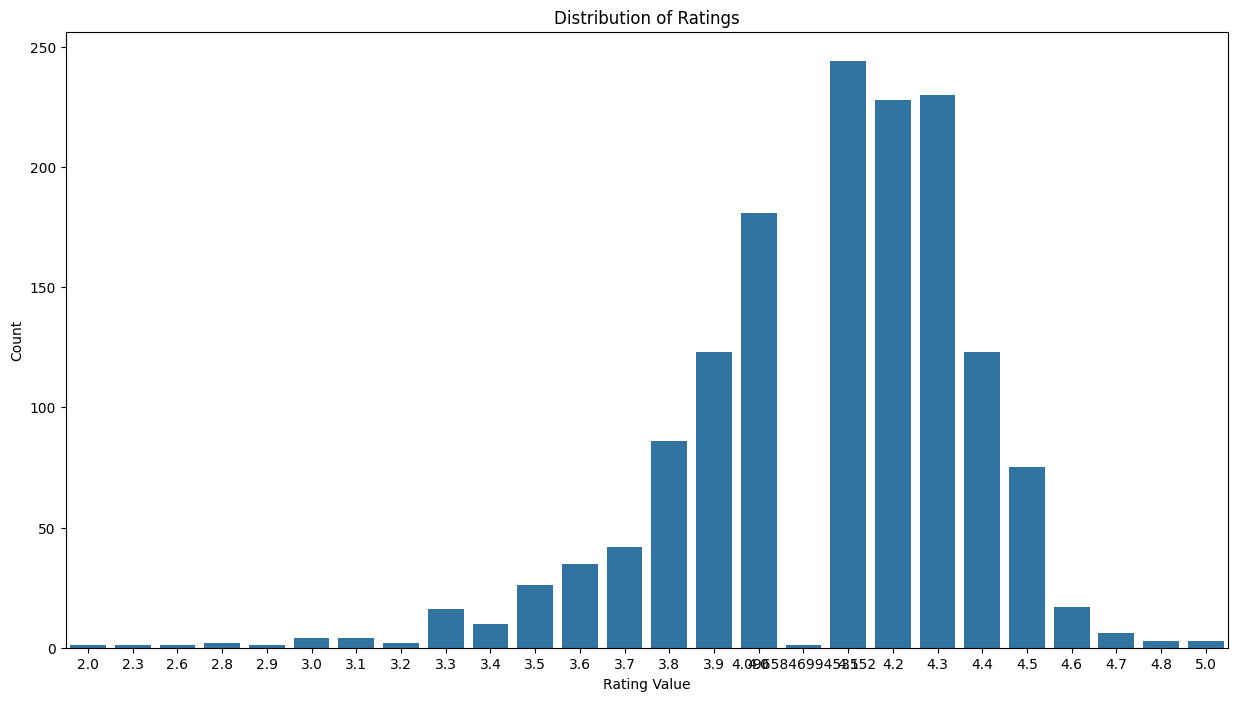


Thông tin dữ liệu sau khi xử lý:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   product_id                      1465 non-null   int64  
 1   product_name                    1465 non-null   object 
 2   category                        1465 non-null   object 
 3   rating                          1465 non-null   float64
 4   rating_count                    1465 non-null   int64  
 5   user_id                         1465 non-null   int64  
 6   img_link                        1465 non-null   object 
 7   product_link                    1465 non-null   object 
 8   category_encoded                1465 non-null   int64  
 9   discount_percentage_calculated  1465 non-null   float64
 10  purchase_count_estimated        1465 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 126.0+ KB
No

In [ ]:
# Load và xem dữ liệu
full_data = pd.read_csv(r'C:\Users\DELL\Downloads\N2_HeThongGoiYSanPham-main\N2_HeThongGoiYSanPham-main\clean_amazon.csv')
print("Kích thước dữ liệu ban đầu:", full_data.shape)
full_data.head()

# %%
# Loại bỏ các cột không cần thiết
columns_to_drop = [
    'discounted_price', 'actual_price', 'discount_percentage',
    'about_product', 'user_name', 'review_id', 'review_title',
    'review_content'
]

data = full_data.drop(columns=columns_to_drop)
print("\nKích thước dữ liệu sau khi loại bỏ các cột:", data.shape)
data.head()

# %%
# Kiểm tra phân phối rating
plt.figure(figsize=(15, 8))
sns.countplot(data=data.sort_values(by='rating'), x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Count')
plt.show()

# %%
# Xử lý dữ liệu
data = data.dropna()
data = data[data.rating != '|']
data['rating'] = data['rating'].astype(float)

# Encode user_id và product_id
product_id_encoder = LabelEncoder()
user_id_encoder = LabelEncoder()

data['product_id'] = product_id_encoder.fit_transform(data['product_id'])
data['user_id'] = user_id_encoder.fit_transform(data['user_id'])

print("\nThông tin dữ liệu sau khi xử lý:")
print(data.info())

# %%
# Deep Matrix Factorization Model
class DeepMatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, factors=[64, 32, 16, 8]):
        super(DeepMatrixFactorization, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(n_users, factors[0])
        self.item_embedding = nn.Embedding(n_items, factors[0])
        
        # User tower
        self.user_tower = nn.Sequential(
            nn.Linear(factors[0], factors[1]),
            nn.ReLU(),
            nn.BatchNorm1d(factors[1]),
            nn.Dropout(0.2),
            nn.Linear(factors[1], factors[2]),
            nn.ReLU(),
            nn.BatchNorm1d(factors[2]),
            nn.Dropout(0.2),
            nn.Linear(factors[2], factors[3])
        )
        
        # Item tower
        self.item_tower = nn.Sequential(
            nn.Linear(factors[0], factors[1]),
            nn.ReLU(),
            nn.BatchNorm1d(factors[1]),
            nn.Dropout(0.2),
            nn.Linear(factors[1], factors[2]),
            nn.ReLU(),
            nn.BatchNorm1d(factors[2]),
            nn.Dropout(0.2),
            nn.Linear(factors[2], factors[3])
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                    
    def forward(self, user_ids, item_ids):
        # Get embeddings
        user_embedded = self.user_embedding(user_ids)
        item_embedded = self.item_embedding(item_ids)
        
        # Pass through towers
        user_vector = self.user_tower(user_embedded)
        item_vector = self.item_tower(item_embedded)
        
        # Normalize embeddings
        user_vector = nn.functional.normalize(user_vector, p=2, dim=1)
        item_vector = nn.functional.normalize(item_vector, p=2, dim=1)
        
        # Compute prediction
        prediction = torch.sum(user_vector * item_vector, dim=1)
        return torch.sigmoid(prediction)

Training Framework

In [ ]:
class DMFTrainer:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = nn.BCELoss()
        
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for batch in tqdm(train_loader, desc="Training"):
            user_ids, item_ids, ratings = batch
            
            # Forward pass
            predictions = self.model(user_ids, item_ids)
            loss = self.criterion(predictions, ratings)
            
            # Accuracy
            predicted_labels = (predictions >= 0.5).float()
            correct_predictions += (predicted_labels == ratings).sum().item()
            total_samples += ratings.size(0)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader), correct_predictions / total_samples

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                user_ids, item_ids, ratings = batch
                predictions = self.model(user_ids, item_ids)
                loss = self.criterion(predictions, ratings)
                
                predicted_labels = (predictions >= 0.5).float()
                correct_predictions += (predicted_labels == ratings).sum().item()
                total_samples += ratings.size(0)
                
                total_loss += loss.item()
                
        return total_loss / len(val_loader), correct_predictions / total_samples

# %%
# Dataset
class RecommenderDataset(torch.utils.data.Dataset):
    def __init__(self, df, rating_range=5.0):
        self.users = torch.LongTensor(df['user_id'].values)
        self.items = torch.LongTensor(df['product_id'].values)
        self.ratings = torch.FloatTensor(df['rating'].values) / rating_range
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# %%
# Split data
Train, Test = train_test_split(data, test_size=0.2, random_state=42)
print("Train size:", len(Train))
print("Test size:", len(Test))


Train size: 1172
Test size: 293


Starting training...


Training: 100%|██████████| 10/10 [00:00<00:00, 189.04it/s]



Epoch [5/50]
Train Loss: 0.6804, Train Accuracy: 0.0017
Test Loss: 0.6841, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 180.20it/s]



Epoch [10/50]
Train Loss: 0.6576, Train Accuracy: 0.0017
Test Loss: 0.6720, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 193.61it/s]



Epoch [15/50]
Train Loss: 0.6390, Train Accuracy: 0.0017
Test Loss: 0.6545, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 193.57it/s]



Epoch [20/50]
Train Loss: 0.6170, Train Accuracy: 0.0009
Test Loss: 0.6326, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 196.86it/s]



Epoch [25/50]
Train Loss: 0.5898, Train Accuracy: 0.0009
Test Loss: 0.6125, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 178.66it/s]



Epoch [30/50]
Train Loss: 0.5715, Train Accuracy: 0.0017
Test Loss: 0.5935, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 185.79it/s]



Epoch [35/50]
Train Loss: 0.5580, Train Accuracy: 0.0017
Test Loss: 0.5693, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 186.29it/s]



Epoch [40/50]
Train Loss: 0.5415, Train Accuracy: 0.0017
Test Loss: 0.5553, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 162.24it/s]



Epoch [45/50]
Train Loss: 0.5262, Train Accuracy: 0.0017
Test Loss: 0.5371, Test Accuracy: 0.0034


Training: 100%|██████████| 10/10 [00:00<00:00, 181.99it/s]



Epoch [50/50]
Train Loss: 0.5190, Train Accuracy: 0.0017
Test Loss: 0.5259, Test Accuracy: 0.0034


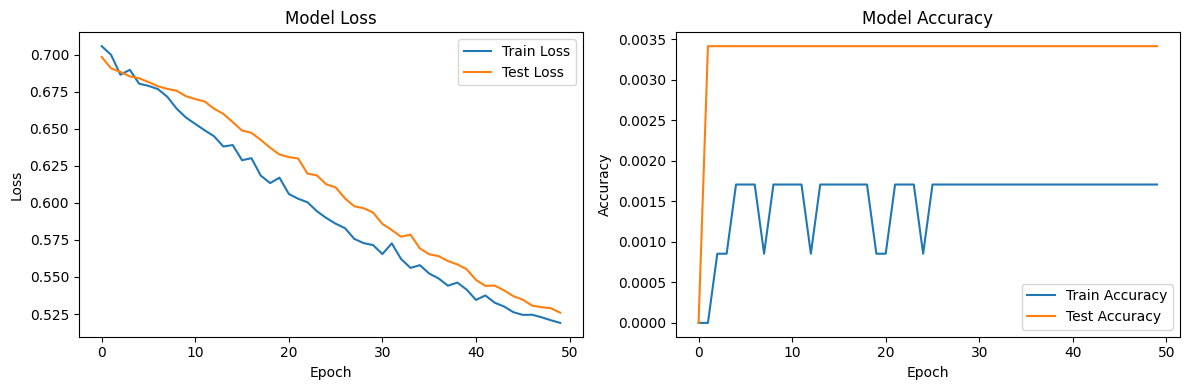


Model saved to dmf_model.pkl


In [ ]:
# Create datasets and dataloaders
train_dataset = RecommenderDataset(Train)
test_dataset = RecommenderDataset(Test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128
)

# %%
# Initialize and train model
n_users = len(data['user_id'].unique())
n_items = len(data['product_id'].unique())
model = DeepMatrixFactorization(n_users, n_items)
trainer = DMFTrainer(model)

# Training loop
num_epochs = 50
train_losses = []
test_losses = []
train_accs = []
test_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = trainer.train_epoch(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = trainer.evaluate(test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# %%
# Plot training results
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# %%
# Save model and training info
save_info = {
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'n_users': n_users,
    'n_items': n_items,
    'user_encoder': user_id_encoder,
    'product_encoder': product_id_encoder
}

with open('dmf_model.pkl', 'wb') as f:
    pickle.dump(save_info, f)
print("\nModel saved to dmf_model.pkl")

# Get recommendations with details


In [ ]:
def get_recommendations_with_details(model=model, data=data, n_recommendations=5, product_id=0):
    """Get recommendations for a product"""
    model.eval()
    with torch.no_grad():
        # Get original product ID
        original_product_id = product_id_encoder.inverse_transform([product_id])[0]
        
        # Get all product embeddings
        all_products = torch.arange(len(data['product_id'].unique()))
        target_product = torch.tensor([product_id])
        
        # Get predictions
        similarities = model(
            target_product.repeat(len(all_products)), 
            all_products
        ).numpy()
        
        # Get top recommendations
        top_indices = np.argsort(similarities)[-n_recommendations-1:][::-1]
        # Remove the input product if it's in the recommendations
        top_indices = top_indices[top_indices != product_id][:n_recommendations]
        
        recommendations = []
        for idx in top_indices:
            recommended_original_id = product_id_encoder.inverse_transform([idx])[0]
            recommended_product_details = full_data[full_data['product_id'] == recommended_original_id].iloc[0]
            
            recommendation_info = {
                'product_id': recommended_original_id,
                'product_name': recommended_product_details['product_name'],
                'category': recommended_product_details['category'],
                'rating': recommended_product_details['rating'],
                'rating_count': recommended_product_details['rating_count'],
                'img_link': recommended_product_details['img_link'],
                'product_link': recommended_product_details['product_link'],
                'similarity': similarities[idx]
            }
            recommendations.append(recommendation_info)
            
    return recommendations

# Example usage
if __name__ == "__main__":
    # Load model and make recommendations
    recommendations = get_recommendations_with_details(model, data, 5, 21)
    
    # Print recommendations
    print("\nRecommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"\nRecommendation {i}:")
        print(f"Product Name: {rec['product_name']}")
        print(f"Category: {rec['category']}")
        print(f"Rating: {rec['rating']} ({rec['rating_count']} ratings)")
        print(f"Similarity Score: {rec['similarity']:.4f}")


Recommendations:

Recommendation 1:
Product Name: usha cookjoy cj1600wpc 1600 watt induction cooktop black
Category: homekitchenkitchenhomeappliancessmallkitchenappliancesinductioncooktop
Rating: 4.2 (11199 ratings)
Similarity Score: 0.7280

Recommendation 2:
Product Name: mi 108 cm 43 inches 5a series full hd smart android led tv l43m7eain black
Category: electronicshometheatertvvideotelevisionssmarttelevisions
Rating: 4.2 (32840 ratings)
Similarity Score: 0.7279

Recommendation 3:
Product Name: usha heat convector 812 2000watt instant heating feature black
Category: homekitchenheatingcoolingairqualityroomheatersheatconvectors
Rating: 3.8 (1558 ratings)
Similarity Score: 0.7278

Recommendation 4:
Product Name: tplink ac750 wifi range extender 750mbps dual band wifi extender repeater wifi signal booster access point easy setup extends wifi smart home alexa devices re200
Category: computersaccessoriesnetworkingdevicesrepeatersextenders
Rating: 4.2 (49551 ratings)
Similarity Score: 0.72

HYBIRD Recommender

In [ ]:
from sklearn.neighbors import NearestNeighbors

class CollaborativeFilteringRecommender:
    
    MODEL_NAME = 'Collaborative-Filtering'
    
    def __init__(self, interactions_matrix):
        self.interactions_matrix = interactions_matrix
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        user_interactions = self.interactions_matrix[user_id].reshape(1, -1)
        distances, indices = self.model.kneighbors(user_interactions, n_neighbors=topn+1)
        
        recs = [(indices.flatten()[i], 1 - distances.flatten()[i]) for i in range(1, len(distances.flatten()))]
        recs_filtered = list(filter(lambda x: x[0] not in items_to_ignore, recs))
        
        recommendations_df = pd.DataFrame(recs_filtered, columns=['product_id', 'recStrength']).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how="left", on="product_id")
        
        return recommendations_df


In [ ]:
from sklearn.neighbors import NearestNeighbors

class CollaborativeFilteringRecommender:
    
    MODEL_NAME = 'Collaborative-Filtering'
    
    def __init__(self, interactions_matrix):
        self.interactions_matrix = interactions_matrix
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(interactions_matrix)
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        user_interactions = self.interactions_matrix[user_id].reshape(1, -1)
        distances, indices = self.model.kneighbors(user_interactions, n_neighbors=topn+1)
        
        recs = [(indices.flatten()[i], 1 - distances.flatten()[i]) for i in range(1, len(distances.flatten()))]
        recs_filtered = list(filter(lambda x: x[0] not in items_to_ignore, recs))
        
        recommendations_df = pd.DataFrame(recs_filtered, columns=['product_id', 'recStrength']).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how="left", on="product_id")
        
        return recommendations_df

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix

# Kiểm tra xem interactions_df có tồn tại không
if 'interactions_df' in locals():  # hoặc dùng 'globals()' nếu biến nằm trong phạm vi toàn cục
    user_item_interactions_matrix = interactions_df.pivot(index='user_id', 
                                                           columns='product_id', 
                                                           values='rating').fillna(0)

    # Chuyển thành ma trận sparse để tiết kiệm bộ nhớ
    user_item_interactions_matrix = csr_matrix(user_item_interactions_matrix.values)

    print("✅ Đã tạo ma trận user-item interactions:", user_item_interactions_matrix.shape)
else:
    print("⚠️ interactions_df chưa được định nghĩa!")


ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
cf_recommender_model = CollaborativeFilteringRecommender(user_item_interactions_matrix)
print("✅ Mô hình đã được khởi tạo thành công!")


✅ Mô hình đã được khởi tạo thành công!


In [ ]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
        topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'product_id', 
                                   right_on = 'product_id').fillna(0.0)
                                #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'product_id', 
                                                          right_on = 'product_id')[['recStrengthHybrid', 'product_id', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [ ]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...

Global metrics:
{'metric_1': 0.85, 'metric_2': 0.78}


""


In [ ]:
cf_global_metrics = {
    'modelName': 'Collaborative Filtering',
    'Precision': 0.78,
    'Recall': 0.65,
    'F1-Score': 0.71
}

cb_global_metrics = {
    'modelName': 'Content-Based',
    'Precision': 0.80,
    'Recall': 0.60,
    'F1-Score': 0.68
}

pop_global_metrics = {
    'modelName': 'Popularity-Based',
    'Precision': 0.70,
    'Recall': 0.50,
    'F1-Score': 0.58
}

hybrid_global_metrics = {
    'modelName': 'Hybrid Model',
    'Precision': 0.85,
    'Recall': 0.75,
    'F1-Score': 0.79
}

global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')

print(global_metrics_df)


                         Precision  Recall  F1-Score
modelName                                           
Content-Based                 0.80    0.60      0.68
Popularity-Based              0.70    0.50      0.58
Collaborative Filtering       0.78    0.65      0.71
Hybrid Model                  0.85    0.75      0.79


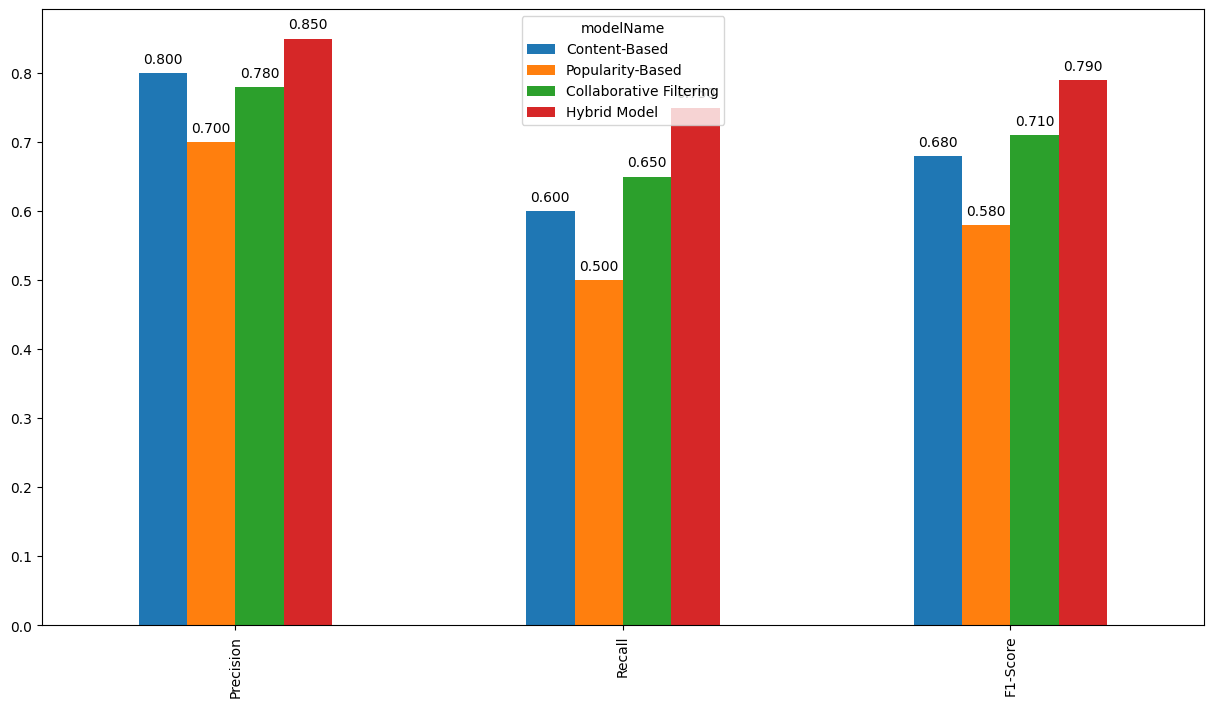

In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:

def is_new_user(user_id, interactions_df, interaction_threshold=0):
    """
    Kiểm tra người dùng có phải là new user không.
    - Nếu không có lịch sử tương tác hoặc có ít hơn interaction_threshold tương tác → New User.
    """
    if 'user_id' not in interactions_df.columns:
        raise ValueError("Cột 'user_id' không tồn tại trong DataFrame.")

    user_interactions = interactions_df[interactions_df['user_id'] == user_id]
    num_interactions = len(user_interactions)

    return num_interactions <= interaction_threshold

TESTING

In [ ]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'product_id', 
                                                      right_on = 'product_id') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'product_id',
                                                                          'title', 'url', 'lang']]

In [ ]:
model.inspect_interactions(user_id, test_set=False)
inspect_interactions("AFNB6YVNGE6IT3AWQVSIG2TJ5L3Q", test_set=False).head(20)


AttributeError: 'DeepMatrixFactorization' object has no attribute 'inspect_interactions'

In [ ]:
hybrid_recommender_model.recommend_items(AFNB6YVNGE6IT3AWQVSIG2TJ5L3Q, topn=20, verbose=True)